<a href="https://colab.research.google.com/github/ErfanRasti/MachineLearningProjects/blob/main/NaturalLanguageProcessing/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='green'>NLP Project</font>

<div class="alert alert-block alert-warning">
<b>
Amirkabir University of Technology<br>
Fall 2022<br>
Course: Machine Learning<br>
Instructor: Dr. Seyedin<br>
<b><font color='green'>Authors:</font></b><br>
Name: Amir Azad <br />
Student Number: 9823004 <br />
Name: Erfan Rasti <br />
Student Number: 9823034 </div>


***

# <font color='purple'>Importing Required Packages</font>

In [1]:
! pip install transformers
! pip install datasets
! pip install sentence-transformers
! pip install evaluate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 17.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 21.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [2]:
# from transformers import AutoTokenizer
import pandas as pd
import torch
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn import metrics
from sentence_transformers import SentenceTransformer
from transformers import TrainingArguments, Trainer
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# <font color='purple'>Loading the dataset from Hugging Face</font>

In [4]:
from datasets import load_dataset
dataset = load_dataset('tweet_eval', 'hate')

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/9000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2970 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2970
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})


In [6]:
print(dataset['train'][0])
print(dataset['test'][2])

{'text': '@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…', 'label': 0}
{'text': '@user @user Those People Invaded Us!!! They DO NOT BELING HERE & HAVE NO RIGHTS! Its #AmericaFIRST! Open Your House To Them If Your That IGNORANT! & Yes Im A #Christian Too! #NODACA!', 'label': 1}


# <font color='purple'>Preprocessing Data</font>


In [7]:
def preprocess_sentence(sentence):
    # remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    # remove whitespace
    sentence = sentence.strip()
    # remove stopwords
    sentence = ' '.join([word for word in sentence.split()
                        if word not in stopwords.words('english')])
    return sentence


In [8]:
def preprocess_dataset(dataset):
    dataset = dataset.map(
        lambda examples: {'text': preprocess_sentence(examples['text'])})
    return dataset


In [9]:
dataset = preprocess_dataset(dataset)
print(dataset['train'][0])
print(dataset['test'][2])

  0%|          | 0/9000 [00:00<?, ?ex/s]

  0%|          | 0/2970 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

{'text': 'user nice new signage Are concerned Beatlemania style hysterical crowds crongregating you…', 'label': 0}
{'text': 'user user Those People Invaded Us They DO NOT BELING HERE HAVE NO RIGHTS Its AmericaFIRST Open Your House To Them If Your That IGNORANT Yes Im A Christian Too NODACA', 'label': 1}


In [10]:
# You can use bert-base or DistilBert as a model
tokenizer = DistilBertTokenizer.from_pretrained(
    'distilbert-base-cased')

def tokenize_dataset(dataset):
    tokenized_dataset = dataset.map(lambda examples: tokenizer(
        examples['text'], truncation=True, padding='max_length'), batched=True)
    return tokenized_dataset


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [11]:
dataset = tokenize_dataset(dataset)
print(dataset['train'][0])
print(dataset['validation'][0])
print(dataset['test'][2])

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

{'text': 'user nice new signage Are concerned Beatlemania style hysterical crowds crongregating you…', 'label': 0, 'input_ids': [101, 4795, 3505, 1207, 2951, 2553, 2372, 4264, 11938, 14183, 11262, 1947, 177, 21878, 4571, 13484, 172, 16822, 1874, 18401, 1128, 795, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# <font color='purple'>Fine-tune a model</font>

You should complete this section

In [20]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased',
    num_labels=2,
    dropout=0.3,
)

training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  save_total_limit=1,
                                  learning_rate=1e-5,
                                  num_train_epochs=3,
                                  weight_decay=0.001,
                                  per_device_eval_batch_size=8,
                                  load_best_model_at_end=True,
                                  optim="adamw_torch")


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.3,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_p

In [21]:
import numpy as np
import evaluate


metrics_to_compute = evaluate.combine([
    evaluate.load("accuracy"),
    evaluate.load("precision", average='weighted'),
    evaluate.load("recall", average='weighted'),
    evaluate.load("f1", average='weighted')
])


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metrics_to_compute.compute(predictions, labels)


In [22]:
# ! rm -rf test_trainer

In [23]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 9000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3375
  Number of trainable parameters = 65783042


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.513000,0.533818,0.734000,0.682540,0.704918,0.693548
2,0.431200,0.573469,0.734000,0.647166,0.829040,0.726899
3,0.397300,0.586434,0.742000,0.667327,0.789227,0.723176


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-1125
Configuration saved in test_trainer/checkpoint-1125/config.json
Model weights saved in test_trainer/checkpoint-1125/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-2250
Configuration saved in test_trainer/checkpoint-2250/config.json
Model weig

TrainOutput(global_step=3375, training_loss=0.45521067527488424, metrics={'train_runtime': 1302.2968, 'train_samples_per_second': 20.733, 'train_steps_per_second': 2.592, 'total_flos': 3576619763712000.0, 'train_loss': 0.45521067527488424, 'epoch': 3.0})

In [26]:
! zip -r test_trainer.zip test_trainer

  adding: test_trainer/ (stored 0%)
  adding: test_trainer/runs/ (stored 0%)
  adding: test_trainer/runs/Jan18_11-50-27_48e0ac4de3db/ (stored 0%)
  adding: test_trainer/runs/Jan18_11-50-27_48e0ac4de3db/events.out.tfevents.1674042629.48e0ac4de3db.141.4 (deflated 58%)
  adding: test_trainer/runs/Jan18_11-50-27_48e0ac4de3db/1674042629.8584247/ (stored 0%)
  adding: test_trainer/runs/Jan18_11-50-27_48e0ac4de3db/1674042629.8584247/events.out.tfevents.1674042629.48e0ac4de3db.141.5 (deflated 62%)
  adding: test_trainer/runs/Jan18_11-49-18_48e0ac4de3db/ (stored 0%)
  adding: test_trainer/runs/Jan18_11-49-18_48e0ac4de3db/1674042559.3401237/ (stored 0%)
  adding: test_trainer/runs/Jan18_11-49-18_48e0ac4de3db/1674042559.3401237/events.out.tfevents.1674042559.48e0ac4de3db.141.3 (deflated 62%)
  adding: test_trainer/runs/Jan18_11-49-18_48e0ac4de3db/events.out.tfevents.1674042559.48e0ac4de3db.141.2 (deflated 58%)
  adding: test_trainer/runs/Jan18_11-48-08_48e0ac4de3db/ (stored 0%)
  adding: test_tra

# <font color='purple'>Evaluation</font>

You should complete this section

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2970
  Batch size = 8


Accuracy:  0.48484848484848486
Precision:  0.6220240181304175
Recall:  0.48484848484848486
F1:  0.40965059632167344
ROC AUC:  0.5445322408477054


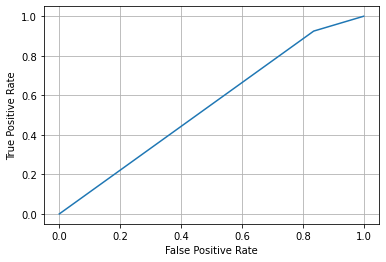

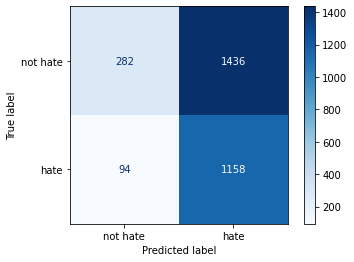

In [24]:
test_pred = trainer.predict(dataset['test']).predictions.argmax(axis=1)
test_true = dataset['test']['label']

print('Accuracy: ', accuracy_score(test_true, test_pred))
print('Precision: ', precision_score(test_true, test_pred, average='weighted'))
print('Recall: ', recall_score(test_true, test_pred, average='weighted'))
print('F1: ', f1_score(test_true, test_pred, average='weighted'))
print('ROC AUC: ', roc_auc_score(test_true, test_pred))

fpr, tpr, thresholds = roc_curve(test_true, test_pred)
roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_plot.plot()
plt.grid()
plt.show()

cm = confusion_matrix(test_true, test_pred)
cm_plot = ConfusionMatrixDisplay(
    cm, display_labels=['not hate', 'hate'])
cm_plot.plot(cmap='Blues')
plt.show()


# <font color='purple'>References</font>

1.   https://huggingface.co/metrics
2.   https://huggingface.co/docs/transformers/training
